# Retrieving Metrics
This notebook demonstrates how to use the API to search and retrieve metrics. Examples here will be shown using Python with the use of the `requests` library, though the same work could be done using the unofficial Python [ADS library](https://ads.readthedocs.io/en/latest/) or `curl` commands on the command line.

## Using the API
In all examples below, `token` should be replaced with [your own API token](https://ui.adsabs.harvard.edu/user/settings/token). If you haven't worked with our API before, it's recommended that you read the [README](https://github.com/adsabs/adsabs-dev-api/blob/master/README.md) before beginning. We also assume some familiarity with our other API Jupyter notebooks, especially the ones on [searching](https://github.com/adsabs/adsabs-dev-api/blob/master/Search_API.ipynb), [retrieving metrics](https://github.com/adsabs/adsabs-dev-api/blob/master/Metrics_API.ipynb), and [using the API with Python](https://github.com/adsabs/adsabs-dev-api/blob/master/Converting_curl_to_python.ipynb).

In [1]:
# import the requests package and set your token in a variable for later use
import requests

token="your-token-here"

## Introduction
In this notebook, we demonstrate how to run a search, export metrics for the search results, and handle the results.

## Searching with the API
Let's start with an example search.

`author:"Payne, Cecelia" year:1920-1979 collection:astronomy`

This search finds papers by the well-known astronomer Cecelia Payne (she also published under her married name, Cecelia Payne-Gaposchkin), active in research from the 1920s to the 1970s. To convert this to a search, we first take the base URL for searching in the API:

`https://api.adsabs.harvard.edu/v1/search/query?`

We'll also need to pick which fields we want to return; since we'll be retrieving metrics for all of the search results, let's only return the bibcode for each search result.

We then need to URL-encode our search terms before we add them to the URL. Python offers an easy way to do this.

In [2]:
from urllib.parse import urlencode
# the search engine will automatically return results for both Cecelia Payne and Cecelia Payne-Gaposchkin
query = 'author:"Payne, Cecelia" year:1920-1979 collection:astronomy'
# the "q" key below designates that this is the search query, while the "fl" refers to the fields to return
encoded_query = urlencode({'q': query, 'fl': 'bibcode'})
encoded_query

'q=author%3A%22Payne%2C+Cecelia%22+year%3A1920-1979+collection%3Aastronomy&fl=bibcode'

We'll append the encoded query terms to the base URL to create the URL we'll send our API request to.

Two other things you'll need to know:
* this API endpoint uses the GET HTTP method, so you'll use the `get` method on the request. (Note that you can find all API endpoints and their HTTP methods in our [full API documentation](https://ui.adsabs.harvard.edu/help/api/api-docs.html).)
* virtually all API requests require you to pass your API token in the header, as shown below

Putting all this together, we can now run our search through the API:

In [3]:
results = requests.get("https://api.adsabs.harvard.edu/v1/search/query?{}".format(encoded_query), \
                       headers={'Authorization': 'Bearer ' + token})
# format the response in a nicely readable format
results.json()

{'responseHeader': {'status': 0,
  'QTime': 38,
  'params': {'q': 'author:"Payne, Cecelia" year:1920-1979 collection:astronomy',
   'fl': 'bibcode',
   'start': '0',
   'internal_logging_params': 'X-Amzn-Trace-Id=Root=1-61bceed5-0739ecb45545bb2a7ecbabcc',
   'rows': '10',
   'wt': 'json'}},
 'response': {'numFound': 296,
  'start': 0,
  'docs': [{'bibcode': '1971SCoA...13.....P'},
   {'bibcode': '1963ApJ...138..320P'},
   {'bibcode': '1964gano.book.....P'},
   {'bibcode': '1966SCoA....9....1P'},
   {'bibcode': '1943AnHar.113....1P'},
   {'bibcode': '1954AnHar.113..189P'},
   {'bibcode': '1974SCoA...16.....P'},
   {'bibcode': '1952AnHar.118....1P'},
   {'bibcode': '1977ASSL...65....3P'},
   {'bibcode': '1946ApJ...104..362P'}]}}

Our query returned 10 results, which is the default number of results to return. However, there are a total of 296 results that match the search (see the `numFound` parameter in the response). We have a couple options to return all of the search results. We could increase the number of results returned to something equal to or larger than the total number of search results using the `rows` parameter (up to a maximum of 2000 rows; see the [full API documentation](https://ui.adsabs.harvard.edu/help/api/api-docs.html) or the [search Jupyter notebook](https://github.com/adsabs/adsabs-dev-api/blob/master/Search_API.ipynb) for more details). Alternatively, we can page through the list of results. 

Since the latter option is slightly more complex, we'll demonstrate that option here. While we're at it, we'll also extract the bibcodes from the dictionary structure they were returned in into a more manageable and useful list.

In [4]:
rows = 10 # fetch 10 records at a time
start = 0  # start with the first result
bibcodes = [] # we'll store the bibcodes of all of our results here

# this is the pagination - the while loop will automatically stop once we've fetched all docs
docs = True
while docs:
    # note that this URL is the same as above, except we've added parameters for start and rows
    results = requests.get("https://api.adsabs.harvard.edu/v1/search/query?{encoded_query}" \
                           "&rows={rows}" \
                           "&start={start}".format(encoded_query=encoded_query,rows=rows,start=start), \
                           headers={'Authorization': 'Bearer ' + token})
    try:
        docs = results.json()['response']['docs']
    except KeyError:
        print('No docs found')
        break
    # pull the bibcodes out of the results into a list
    tmp = [d['bibcode'] for d in docs]
    bibcodes = bibcodes + tmp
    start += rows # increment the start value to move to the next page of results

print(len(bibcodes))

296


Ok, we've now completed the search and extracted all of the search results into a list. Let's move on to retrieving metrics for them.

## Retrieving metrics
The metrics input and output from the API is quite complex. Before we begin, note that there are more help resources are availble as needed:
* [Full API documentation](https://ui.adsabs.harvard.edu/help/api/api-docs.html#post-/metrics)
* [Metrics API notebook](https://github.com/adsabs/adsabs-dev-api/blob/master/Metrics_API.ipynb)
* [Metrics help pages](https://ui.adsabs.harvard.edu/help/actions/analyze)

We'll be mostly exploring requests using the most common metrics API endpoint. The base URL for this is:

`https://api.adsabs.harvard.edu/v1/metrics`

This endpoint is used with the POST HTTP method. The payload includes a list of input bibcodes (the result from our search, above), and optionally, the types of metrics to output (given as a list). There are 5 different types of metrics output available; if `types` is not specified in the request, all 5 types will be returned. However, for the sake of explanation, we'll take them one at a time in this notebook.

### Basic metrics
Adding a `types` of `basic` to your payload will return the basic metrics, which includes high-level information on the number of papers, reads, and downloads.


In [5]:
# create a dictionary with the payload values
payload = {"bibcodes": bibcodes, "types": ["basic"]}

# the json library offers an easy way to convert between JSON or dictionaries and their serialized strings
import json
serialized_payload = json.dumps(payload)

results = requests.post("https://api.adsabs.harvard.edu/v1/metrics", 
                        headers={'Authorization': 'Bearer ' + token, "Content-type": "application/json"},
                        data=json.dumps(payload))

results.json()

{'skipped bibcodes': [],
 'basic stats': {'number of papers': 296,
  'normalized paper count': 247.47619047619048,
  'total number of reads': 19114,
  'average number of reads': 65,
  'median number of reads': 16.0,
  'recent number of reads': 1842,
  'total number of downloads': 9795,
  'average number of downloads': 33.316326530612244,
  'median number of downloads': 9.0,
  'recent number of downloads': 832},
 'basic stats refereed': {'number of papers': 81,
  'normalized paper count': 62.75,
  'total number of reads': 13361,
  'average number of reads': 167,
  'median number of reads': 40.5,
  'recent number of reads': 1466,
  'total number of downloads': 7237,
  'average number of downloads': 90.4625,
  'median number of downloads': 24.0,
  'recent number of downloads': 636}}

The response always includes the `skipped_bibcodes` key; if metrics couldn't be retrieved for some input bibcodes, they'd be listed here.

### Citations
The next metrics type that can be retrieves is `citations`. This retrieves high-level information on the number of citations, organized in different ways, to the input bibcodes.

In [6]:
payload = {"bibcodes": bibcodes, "types": ["citations"]}
serialized_payload = json.dumps(payload)

results = requests.post("https://api.adsabs.harvard.edu/v1/metrics", 
                        headers={'Authorization': 'Bearer ' + token, "Content-type": "application/json"},
                        data=json.dumps(payload))

results.json()

{'skipped bibcodes': [],
 'citation stats': {'number of citing papers': 825,
  'number of self-citations': 6,
  'self-citations': ['1977ASSL...65....3P',
   '1933PNAS...19..641M',
   '1966VA......8..191P',
   '1933PNAS...19..641M',
   '1956VA......2.1142P',
   '1933PNAS...19..641M'],
  'total number of citations': 899,
  'average number of citations': 3.0371621621621623,
  'median number of citations': 0.0,
  'normalized number of citations': 773.1666666666666,
  'total number of refereed citations': 773,
  'average number of refereed citations': 2.6114864864864864,
  'median number of refereed citations': 0.0,
  'normalized number of refereed citations': 668.0},
 'citation stats refereed': {'number of citing papers': 505,
  'number of self-citations': 5,
  'total number of citations': 536,
  'average number of citations': 6.617283950617284,
  'median number of citations': 1.0,
  'normalized number of citations': 458.99999999999994,
  'total number of refereed citations': 464,
  'avera

You can extract a specific value from the dictionary response like this:

In [7]:
results.json()['citation stats']['number of citing papers']

825

### Indicators
The third type of metrics that can be retrieved is `indicators`. This returns calculated values of things like the h-index, m-index, and other statistics. See our [metrics help page](https://ui.adsabs.harvard.edu/help/actions/analyze) for more information about how these are calculated. 

Note that the values retrieved with `indicators` are one-time values, calculated over the lifetime of the dataset. To retrieve year-by-year indicators, see the `timeseries` metrics type, below.

In [8]:
payload = {"bibcodes": bibcodes, "types": ["indicators"]}
serialized_payload = json.dumps(payload)

results = requests.post("https://api.adsabs.harvard.edu/v1/metrics", 
                        headers={'Authorization': 'Bearer ' + token, "Content-type": "application/json"},
                        data=json.dumps(payload))

results.json()

{'skipped bibcodes': [],
 'indicators': {'h': 17,
  'g': 27,
  'i10': 24,
  'i100': 0,
  'm': 0.1717171717171717,
  'read10': 0.0,
  'tori': 36.05652339755395,
  'riq': 105},
 'indicators refereed': {'h': 12,
  'g': 22,
  'i10': 14,
  'i100': 0,
  'm': 0.12121212121212122,
  'read10': 0.0,
  'tori': 19.930435020632338,
  'riq': 78}}

### Time series
The next type of metrics that can be retrieved is `timeseries`. These are similar to `indicators`, above, but calculated on a year-by-year basis.

In [9]:
payload = {"bibcodes": bibcodes, "types": ["timeseries"]}
serialized_payload = json.dumps(payload)

results = requests.post("https://api.adsabs.harvard.edu/v1/metrics", 
                        headers={'Authorization': 'Bearer ' + token, "Content-type": "application/json"},
                        data=json.dumps(payload))

results.json()

{'skipped bibcodes': [],
 'time series': {'i10': {'1923': 0,
   '1924': 0,
   '1925': 0,
   '1926': 0,
   '1927': 0,
   '1928': 0,
   '1929': 0,
   '1930': 0,
   '1931': 0,
   '1932': 0,
   '1933': 0,
   '1934': 0,
   '1935': 0,
   '1936': 0,
   '1937': 0,
   '1938': 0,
   '1939': 0,
   '1940': 0,
   '1941': 0,
   '1942': 0,
   '1943': 0,
   '1944': 0,
   '1945': 0,
   '1946': 0,
   '1947': 0,
   '1948': 0,
   '1949': 0,
   '1950': 0,
   '1951': 0,
   '1952': 0,
   '1953': 0,
   '1954': 0,
   '1955': 0,
   '1956': 0,
   '1957': 0,
   '1958': 0,
   '1959': 0,
   '1960': 0,
   '1961': 0,
   '1962': 0,
   '1963': 0,
   '1964': 0,
   '1965': 0,
   '1966': 0,
   '1967': 0,
   '1968': 0,
   '1969': 0,
   '1970': 0,
   '1971': 0,
   '1972': 0,
   '1973': 0,
   '1974': 2,
   '1975': 2,
   '1976': 3,
   '1977': 5,
   '1978': 6,
   '1979': 6,
   '1980': 6,
   '1981': 6,
   '1982': 8,
   '1983': 8,
   '1984': 8,
   '1985': 9,
   '1986': 11,
   '1987': 12,
   '1988': 13,
   '1989': 15,
   '1990': 

Since we have year-by-year information, we can plot the data, similar to the figures available on the ADS website.

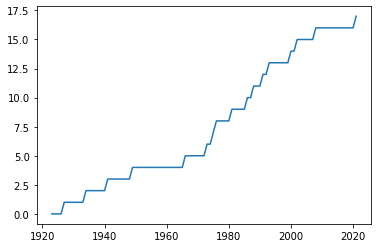

In [10]:
import matplotlib.pyplot as plt

# extract the relevant info to separate variables for readability
# while you're at it, convert the year strings to integers
x = list(int(r) for r in results.json()['time series']['h'].keys())
y_h = list(results.json()['time series']['h'].values())

plt.plot(x, y_h)
plt.show()

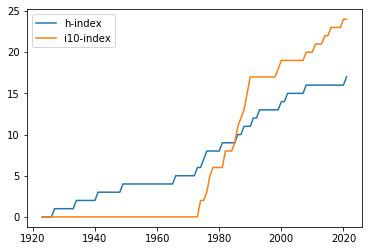

In [11]:
y_i = list(results.json()['time series']['i10'].values())

plt.plot(x, y_h, label='h-index')
plt.plot(x, y_i, label='i10-index')
plt.legend()
plt.show()

### Histograms
The final type of metrics available is `histograms`. There are four subtypes of histogram data available:
* publications: refers to the number of records per year
* reads: number of reads per year
* downloads: number of paper downloads per year
* citations: citations per year

By default, all histogram subtypes are returned; use the key `histograms` to specify a list of one or more subtypes to return as needed. Within each subtype, information for multiple histograms is returned. Refer to the full documentation for more information.

In [12]:
payload = {"bibcodes": bibcodes, "types": ["histograms"], "histograms": ["publications"]}
serialized_payload = json.dumps(payload)

results = requests.post("https://api.adsabs.harvard.edu/v1/metrics", 
                        headers={'Authorization': 'Bearer ' + token, "Content-type": "application/json"},
                        data=json.dumps(payload))

results.json()

{'skipped bibcodes': [],
 'histograms': {'publications': {'all publications': {'1923': 1,
    '1924': 41,
    '1925': 5,
    '1926': 21,
    '1927': 22,
    '1928': 14,
    '1929': 7,
    '1930': 11,
    '1931': 9,
    '1932': 10,
    '1933': 12,
    '1934': 3,
    '1935': 8,
    '1936': 7,
    '1937': 2,
    '1938': 4,
    '1939': 3,
    '1940': 1,
    '1941': 3,
    '1942': 5,
    '1943': 3,
    '1944': 2,
    '1945': 1,
    '1946': 10,
    '1947': 1,
    '1948': 0,
    '1949': 0,
    '1950': 1,
    '1951': 3,
    '1952': 28,
    '1953': 1,
    '1954': 3,
    '1955': 2,
    '1956': 2,
    '1957': 1,
    '1958': 3,
    '1959': 0,
    '1960': 0,
    '1961': 3,
    '1962': 0,
    '1963': 6,
    '1964': 2,
    '1965': 1,
    '1966': 3,
    '1967': 1,
    '1968': 0,
    '1969': 2,
    '1970': 2,
    '1971': 4,
    '1972': 2,
    '1973': 2,
    '1974': 5,
    '1975': 1,
    '1976': 2,
    '1977': 5,
    '1978': 1,
    '1979': 4,
    '1980': 0,
    '1981': 0,
    '1982': 0,
    '1983': 0,
 

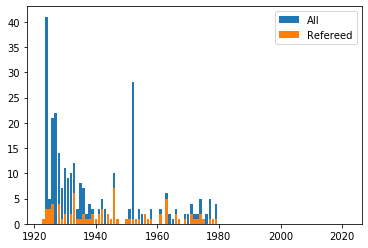

In [13]:
x = list(int(r) for r in results.json()['histograms']['publications']['all publications'].keys())
y_all = list(results.json()['histograms']['publications']['all publications'].values())
y_ref = list(results.json()['histograms']['publications']['refereed publications'].values())

plt.bar(x, y_all, label="All")
plt.bar(x, y_ref, label="Refereed")
plt.legend()
plt.show()